# ML Development

In [1]:
%load_ext autoreload
%autoreload 2

::: {.content-hidden}
Import necessary Python modules
:::

In [2]:
import json
import os
import sys
from datetime import datetime
from functools import reduce
from glob import glob
from pathlib import Path

import joblib
import mlflow.sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as skm
from feature_engine.encoding import RareLabelEncoder
from feature_engine.selection import DropCorrelatedFeatures
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import ticker
from matplotlib.lines import Line2D
from mlflow import MlflowClient
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.utils.validation import check_is_fitted

::: {.content-hidden}
Get relative path to project root directory
:::

In [3]:
PROJ_ROOT_DIR = os.path.join(os.pardir)
src_dir = os.path.join(PROJ_ROOT_DIR, "src")
sys.path.append(src_dir)

::: {.content-hidden}
Import custom Python modules
:::

In [4]:
%aimport bigquery_auth_helpers
from bigquery_auth_helpers import auth_to_bigquery

%aimport categorical_helpers
import categorical_helpers as ch

%aimport eda_helpers
import eda_helpers as eh

%aimport feature_helpers
import feature_helpers as fh

%aimport metrics_helpers
import metrics_helpers as mh

%aimport model_helpers
import model_helpers as modh

%aimport preprocess_helpers
import preprocess_helpers as ph

%aimport sklearn_helpers
import sklearn_helpers as skh

%aimport sql_helpers
import sql_helpers as sqlh

%aimport transform_helpers
import transform_helpers as th

%aimport viz_helpers
import viz_helpers as vh

%aimport xy_helpers
import xy_helpers as xyh

%aimport utils
import utils as ut

## About

### Overview
Train a ML model to predict first-time US-based visitors' propensity to make a purchase on a return visit to the Google merchandise store.

### Data
Visit data is taken from [Google Cloud's public dataset with Google Analytics visitor transaction data](https://support.google.com/analytics/answer/7586738?hl=en&ref_topic=3416089&sjid=3563149692393307347-NA#zippy=%2Cin-this-article).

### Timelines and Data Splits
The study timeline covers several months. During the study period, the visitor ID of every visitor who made a return visit to the store is retrieved. The ML model will be developed using the first visit by these visitors only, since there isn't any useful information to be learnt from visitors who made a single visit to the store without returning. The attributes of the first visit to the store by the return visitors will be used when splitting the data for use in ML model development. Three data splits are created for ML model development, which includes model training, validation and evaluation. As mentioned above, the data splits combine to cover the study period and they occur in chronological order.

The training data split covers the first several months of available data and it captures attributes of the first-time visitors who were found to make a return visit to the store during the study period. The first visit occurs during these pre-determined months. The validation split covers first-time visitors to the store during the month that follows the last month of training data. Similarly, the test data split covers visitors during the month following the validation data period.

### ML Model Development
The ML model is trained using the training data and scored on the validation data. Features are engineered and pre-processed using the training and validation data splits. Due to the class imbalance with most visitors not making a purchase during a return visit, over- and under-sampling techniques are used to help the model learn from attributes of first-time visits that resulted in a purchase. A ML pipeline is developed using the [`scikit-learn` ML framework for tabular data](https://scikit-learn.org/stable/) with the [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) class. The pipeline covers all the [steps that are part of typical ML training](https://ml-course.github.io/master/notebooks/06%20-%20Data%20Preprocessing.html#lecture-6-data-preprocessing), including feature engineering, pre-processing, feature selection and re-sampling (over- or under-sampling) and classification steps. If over-sampling is chosen, then this step is performed after the pre-processing step and before the classification step. If under-sampling is performed, then re-sampling is performed as the first step of the pipeline.

### ML Evaluation
As mentioned in the project scope, a single evaluation metric is preferred for this project. For comparison purposes, several metrics will be computed. Model selection (next step) will be performed using the primary (preferred) metric only.

### ML Experiment Tracking
During this step, one or more runs of a single or multiple ML experiments will be executed.

A single run of a single experiment consists of training and evaluating a single pipeline (model). A grid of model hyperparameters for the pipeline is defined in the **User Inputs** section. These hyperparameters will be optimized (tuned) by training the pipeline on the training data split and scoring its predictions on the validation data. The best hyperparameters for the pipeline will be the ones that return the best evaluation metric on the validation data. The pipeline with the best hyperparameters will then be re-trained using the combined training and validation data and it will be used to predict and evaluate observations in the test data split. At the end of a single experiment run, all the metadata (eg. features used, best pipeline hyperparameters, metrics, etc.) and metrics associated with that run are tracked using the [MLFlow ML lifecycle management platform](https://mlflow.org/).

During the next step, the pipeline (model) with the best metric (score) on the test data split will be determined by retrieving the metadata for all experiment runs and ranking the runs based on the scoring metric on the test data split. The best model will then be tagged for further use (to generate a marketing audience) during a later step in this project.

## User Inputs

Define the following

1. start and end dates for train, validation and test data
2. list of categorical features
3. list of categorical features present in the raw data as integers
4. list of numerical features
5. datetime features
6. features to exclude
7. name of column containing label (outcome)
8. resampling approach (over- or under-sampling)
9. primary ML scoring metric
10. hyperparameter grid
11. type of `scikit-learn` ML model
12. MLFlow-related inputs for experiment tracking

In [5]:
#| echo: true
# 1. start and end dates
train_start_date = "20160901"
train_end_date = "20161231"
val_start_date = "20170101"
val_end_date = "20170131"
test_start_date = "20170201"
test_end_date = "20170228"

# 2. categorical column
categorical_features = [
    "bounces",
    "last_action",
    "source",
    "medium",
    "channelGrouping",
    "browser",
    "os",
    "deviceCategory",
]

# 3. categorical columns present as integers
categorical_features_ints = ["bounces"]

# 4. numerical columns
numerical_features = [
    "hits",
    "promos_displayed",
    "promos_clicked",
    "product_views",
    "product_clicks",
    "pageviews",
    "time_on_site",
]

# 5. datetime features
datetime_features = ["quarter", "month", "day_of_month", "day_of_week", "hour"]

# 6. features to exclude
cols_to_drop = ["fullvisitorid", "visitId", "visitNumber", "visitStartTime"]

# 7. label column
label = "made_purchase_on_future_visit"

# 8. resampling
resampling_approach = "os"

# 9. scoring metric
primary_metric = "fbeta2"

# 10. define hyperParameter grid
param_grid = {
    "resampler__sampling_strategy": [0.1],
    "select__threshold": [0.7],
    "preprocessor__cat__rarecats__fe__tol": [0.10],
    "preprocessor__cat__rarecats__fe__n_categories": [1],
    "preprocessor__cat__rarecats__fe__ignore_format": [True],
    "preprocessor__cat__rarecats__fe__replace_with": ["other"],
    # "clf__strategy": ["stratified"],  # model_type = DummyClassifier
    "clf__a": [0.2, 0.3, 0.4, 0.35, 0.15, 0.45],  # model_type = BetaDistClassifier
    "clf__b": [2.31, 2.25, 2.35, 2.4, 2.5],  # model_type = BetaDistClassifier
}

# 11. type of model
model_type = "BetaDistClassifier"

# 12. mlflow
mlflow_expt_name = "My Demo Experiment 2"
mlflow_unwanted_tracking_cols = [
    "tags.mlflow.source.name",
    "tags.mlflow.source.type",
    "tags.mlflow.user",
    "artifact_uri",
    "start_time",
    "end_time",
]
cleanup_mlflow = True

::: {.content-hidden}
Get path to data sub-folders and model folder
:::

In [6]:
data_dir = os.path.join(PROJ_ROOT_DIR, "data")
raw_data_dir = os.path.join(data_dir, "raw")
processed_data_dir = os.path.join(data_dir, "processed")
models_dir = os.path.join(PROJ_ROOT_DIR, "models")

::: {.content-hidden}
Define MLFlow storage paths
:::

In [7]:
mlruns_db_fpath = f"{raw_data_dir}/mlruns.db"
mlflow_artifact_fpath = os.path.relpath(os.path.join(os.getcwd(), "mlruns"))
mlflow.set_tracking_uri(f"sqlite:///{mlruns_db_fpath}")

::: {.content-hidden}
Set environment variable to silence MLFlow `git` warning messsage
:::

In [8]:
os.environ["GIT_PYTHON_REFRESH"] = "quiet"

::: {.content-hidden}
Define dictionary of models (classifiers) to be used as last step in `Pipeline`
:::

In [9]:
models = {
    "DummyClassifier": DummyClassifier(random_state=88),
    "LogisticRegression": LogisticRegression(random_state=88),
    "RandomForestClassifier": RandomForestClassifier(random_state=88),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=88),
    "BetaDistClassifier": skh.BetaDistClassifier(random_state=88),
}

::: {.content-hidden}
Define a dictionary to specify datatypes of the transformed data
:::

In [10]:
dtypes_dict = {
    "fullvisitorid": pd.StringDtype(),
    "visitId": pd.StringDtype(),
    "visitNumber": pd.Int8Dtype(),
    "quarter": pd.Int8Dtype(),
    "month": pd.Int8Dtype(),
    "day_of_month": pd.Int8Dtype(),
    "day_of_week": pd.Int8Dtype(),
    "hour": pd.Int8Dtype(),
    "minute": pd.Int8Dtype(),
    "second": pd.Int8Dtype(),
    "source": pd.CategoricalDtype(),  #
    "medium": pd.CategoricalDtype(),  #
    "channelGrouping": pd.CategoricalDtype(),  #
    "hits": pd.Int16Dtype(),
    "bounces": pd.CategoricalDtype(),  #
    "last_action": pd.CategoricalDtype(),  #
    "promos_displayed": pd.Int16Dtype(),
    "promos_clicked": pd.Int16Dtype(),
    "product_views": pd.Int16Dtype(),
    "product_clicks": pd.Int16Dtype(),
    "pageviews": pd.Int16Dtype(),
    "time_on_site": pd.Int16Dtype(),
    "browser": pd.CategoricalDtype(),  #
    "os": pd.CategoricalDtype(),  #
    "added_to_cart": pd.Int16Dtype(),
    "deviceCategory": pd.CategoricalDtype(),  #
    "made_purchase_on_future_visit": pd.Int8Dtype(),
}

::: {.content-hidden}
Create a mapping between action type integer and label, in order to get meaningful names from the `action_type` column
:::

In [11]:
action_mapper = {
    1: "Click through of product lists",
    2: "Product detail views",
    3: "Add product(s) to cart",
    4: "Remove product(s) from cart",
    5: "Check out",
    6: "Completed purchase",
    7: "Refund of purchase",
    8: "Checkout options",
    0: "Unknown",
}

A helper function will be created to programmatically load data from BigQuery based on the desired start and end dates. The function accepts the following

1. start and end dates for which data is to be retrieved
   - these dates will be different for the training, validation and test splits
2. start date for the training data and end date for the test data
   - these two dates define the period over which ML model development will occur
   - these are used to retrieve visitors who made a purchase on a return (future) visit to the store during this period

The function is defined in `src/sql_helpers.py`.

::: {.content-hidden}
## Authenticate to `BigQuery`
:::

In [12]:
gcp_auth_dict = auth_to_bigquery(raw_data_dir)

## Get Data

### Train

In [13]:
#| echo: true
query_train = sqlh.get_sql_query(
    train_start_date, train_end_date, train_start_date, test_end_date
)
df_train, _ = th.extract_data(query_train, gcp_auth_dict).pipe(
    th.transform_data,
    datatypes_dict=dtypes_dict,
    duplicate_cols=["fullvisitorid"],
    column_mapper_dict={'last_action': action_mapper},
    # categoricals=list(set(categorical_features) - set(categorical_features_ints)),
)
# df_train.pipe(th.load_data, processed_data_dir, "train")

Query execution start time = 2023-06-05 18:48:53.870...done at 2023-06-05 18:49:10.040 (16.170 seconds).
Query returned 92,859 rows
Got 92,551 rows and 28 columns after dropping duplicates
Transformed data has 92,551 rows & 28 columns
CPU times: user 3.72 s, sys: 335 ms, total: 4.06 s
Wall time: 16.3 s


### Validation

In [14]:
#| echo: true
query_val = sqlh.get_sql_query(val_start_date, val_end_date, train_start_date, test_end_date)
df_val, _ = th.extract_data(query_val, gcp_auth_dict).pipe(
    th.transform_data,
    datatypes_dict=dtypes_dict,
    duplicate_cols=["fullvisitorid"],
    column_mapper_dict={'last_action': action_mapper},
)
# df_val.pipe(th.load_data, processed_data_dir, "val")

Query execution start time = 2023-06-05 18:49:10.140...done at 2023-06-05 18:49:14.773 (4.633 seconds).
Query returned 21,208 rows
Got 21,177 rows and 28 columns after dropping duplicates
Transformed data has 21,177 rows & 28 columns
CPU times: user 927 ms, sys: 97.1 ms, total: 1.02 s
Wall time: 4.65 s


### Test

In [15]:
#| echo: true
query_test = sqlh.get_sql_query(test_start_date, test_end_date, train_start_date, test_end_date)
df_test, cat_mapper_dicts_test = th.extract_data(query_test, gcp_auth_dict).pipe(
    th.transform_data,
    datatypes_dict=dtypes_dict,
    duplicate_cols=["fullvisitorid"],
    column_mapper_dict={'last_action': action_mapper},
)
# df_test.pipe(th.load_data, processed_data_dir, "test")

Query execution start time = 2023-06-05 18:49:14.814...done at 2023-06-05 18:49:19.494 (4.680 seconds).
Query returned 20,180 rows
Got 20,164 rows and 28 columns after dropping duplicates
Transformed data has 20,164 rows & 28 columns
CPU times: user 864 ms, sys: 43.8 ms, total: 908 ms
Wall time: 4.7 s


### Combine Data and Split for ML Validation

Create combined training and validation data, where only the training data has been shuffled

In [16]:
#| echo: true
df_train, df_train_val = th.create_combined_validation_data(df_train, df_val, dtypes_dict)

CPU times: user 130 ms, sys: 1.19 ms, total: 131 ms
Wall time: 133 ms


### Combine Data for ML Evaluation

Create combined training and validation data that has been shuffled

In [17]:
#| echo: true
df_train_val_eval = (
    pd.concat([df_train, df_val])
    .pipe(th.set_datatypes, dtypes_dict)
    .pipe(th.shuffle_data)
)

CPU times: user 83.4 ms, sys: 64 µs, total: 83.4 ms
Wall time: 83 ms


### Combine Data for Inference

Shuffle all available data

In [18]:
#| echo: true
df_all = (
    pd.concat([df_train, df_val, df_test])
    .pipe(th.set_datatypes, dtypes_dict)
    .pipe(th.shuffle_data)
)

CPU times: user 69.1 ms, sys: 23 ms, total: 92 ms
Wall time: 91.6 ms


### Separate Features and Label

In [19]:
#| echo: true
(
    X_train,
    y_train,
    X_val,
    y_val,
    X_train_val,
    y_train_val,
    X_train_val_eval,
    y_train_val_eval,
    X_test,
    y_test,
    X,
    y,
) = xyh.get_feats_label(
    df_train,
    df_val,
    df_train_val,
    df_train_val_eval,
    df_test,
    df_all,
    cols_to_drop,
    label,
)

CPU times: user 60.2 ms, sys: 281 µs, total: 60.4 ms
Wall time: 60 ms


## Exploratory Data Analysis

Get features that will be used in ML development (excludes ID features such as `fullvisitorid`, etc.)

In [ ]:
X_train_feats = X_train[
    datetime_features + numerical_features + categorical_features
].copy()

In [20]:
X_train_feats.head()

,quarter,month,day_of_month,day_of_week,hour,hits,promos_displayed,promos_clicked,product_views,product_clicks,pageviews,time_on_site,bounces,last_action,source,medium,channelGrouping,browser,os,deviceCategory
35089,4,12,21,4,11,5,18,0,19,0,5,144,0,Unknown,bing,organic,Organic Search,Chrome,Chrome OS,desktop
52573,4,10,12,4,18,1,0,0,0,0,1,0,1,Unknown,baidu,organic,Organic Search,Safari (in-app),iOS,mobile
40348,4,11,10,5,12,1,0,0,0,0,1,0,1,Unknown,google,cpc,Paid Search,Chrome,Windows,desktop
91912,4,11,25,6,10,1,0,0,12,0,1,0,1,Unknown,google,organic,Organic Search,Chrome,Android,mobile
9236,4,12,16,6,21,2,9,0,9,0,2,42,0,Unknown,mall.googleplex.com,referral,Referral,Chrome,Macintosh,desktop


### Multi-Collinearity

::: {.content-hidden}
Convert categorical columns to integers
:::

In [21]:
X_train_feats_corr, cat_mapper_dicts_train = X_train_feats.pipe(
    ch.cast_categoricals_as_ints, categoricals=categorical_features
)

Check for multi-collinearity among all features using feature correlation heatmap

In [22]:
X_train_corr = X_train_feats_corr.corr()
X_train_corr = (
    pd.DataFrame(
        np.tril(X_train_corr.to_numpy()),
        columns=list(X_train_feats_corr),
        index=list(X_train_feats_corr),
    )
    .replace(0, np.nan)
    .where(np.identity(X_train_corr.shape[0]) != 1, np.nan)
    .dropna(axis=1, how="all")
)
with pd.option_context("display.max_columns", None):
    display(
        X_train_corr.style.background_gradient(cmap="YlOrRd").set_properties(
            **{"font-size": "14px"}
        )
    )

,quarter,month,day_of_month,day_of_week,hour,hits,promos_displayed,promos_clicked,product_views,product_clicks,pageviews,time_on_site,bounces,last_action,source,medium,channelGrouping,browser,os
quarter,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
month,0.749119,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
day_of_month,-0.009950,-0.058842,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
day_of_week,-0.044626,-0.011715,-0.053364,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
hour,0.008207,0.008810,-0.006907,-0.022011,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
hits,-0.016884,-0.012355,-0.012070,-0.003050,0.032749,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
promos_displayed,-0.022550,-0.030020,-0.032407,-0.001648,0.022424,0.427202,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
promos_clicked,-0.051911,-0.097672,-0.043572,0.006453,0.026423,0.254160,0.483343,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
product_views,-0.239557,-0.187650,-0.032899,0.002638,0.039686,0.743049,0.347107,0.250329,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
product_clicks,-0.036241,-0.028998,-0.005506,-0.001997,0.023777,0.849215,0.199485,0.119974,0.566139,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


::: {.callout-tip title="Observations"}

1. `pageviews` is
   - highly correlated (>0.7) to `hits`, `product_clicks` and `product_views`
   - moderately correlated (>0.5 and <0.7) to `last_action`
2. `product_clicks` and `product_views` are highly correlated to `hits`.
3. `last_action` is moderately correlated to `time_on_site`.
4. To allow ML model explainability, multi-collinearity must be removed from the features. So, highly-correlated features will have to be dropped. Moderately correlated features will be permitted.
:::

### Correlation to Label

::: {.content-hidden}
Show feature correlation to label
:::

In [23]:
Xy_corr = (
    pd.concat([X_train_feats_corr, y_train], axis=1)
    .corr()[[label]]
    .reset_index()
    .rename(columns={"index": "feature"})
    .query(f"feature != '{label}'")
    .rename(columns={label: "corr"})
    .sort_values(by=["corr"], ascending=False, ignore_index=True)
    .assign(
        feature_type=lambda df: df["feature"].map(
            {
                c: ct
                for c, ct in zip(
                    categorical_features + numerical_features + datetime_features,
                    ["categorical"] * len(categorical_features)
                    + ["numerical"] * len(numerical_features)
                    + ["datetime"] * len(datetime_features),
                )
            }
        )
    )
)
with pd.option_context("display.max_columns", None):
    display(
        Xy_corr.style.background_gradient(cmap="YlOrRd", subset=["corr"])
        .set_properties(**{"font-size": "14px"})
        .applymap(
            lambda x: "background-color : yellow"
            if x == "categorical"
            else ("background-color : lightgreen" if x == "numerical" else "")
        )
    )

,feature,corr,feature_type
0,last_action,0.224859,categorical
1,pageviews,0.146607,numerical
2,hits,0.142694,numerical
3,time_on_site,0.126974,numerical
4,product_clicks,0.106253,numerical
5,product_views,0.068049,numerical
6,month,0.050306,datetime
7,quarter,0.043374,datetime
8,promos_displayed,0.032403,numerical
9,source,0.021992,categorical


::: {.callout-tip title="Observations"}

1. Unfortunately, the extracted features show a weak correlation (<0.5) to the label.
2. The first-time visitors' `last_action` (i.e. the last action they performed during their first visit) shows the highest correlation (0.23) to the label. This is a categorical feature (hilighted in yellow). The other categorcal features show a weak correlation to the label.
3. The numerical features (hilighted in light-green above) show the next strongest correlations (>0.06 and <0.15) to the label, but some of these features are highly correlated to eachother (as seen above) and so a subset of these numerical features will be excluded in order to support model explainability.
4. The `datetime` features (not hilighted above) are treated like categoricals in the extracted data, and they show a poor correlation to the label. Other approaches to encoding `datetime` attributes (eg. using [trigonometric functions](https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca)) should be explored during feature pre-processing.
:::

### Cardinality of Categorical Features

::: {.content-hidden}
Show cardinality for categorical features
:::

In [24]:
with pd.option_context("display.max_colwidth", 150):
    display(
        ch.combine_categorical_str_to_int_mappers(
            [cat_mapper_dicts_train], [X_train_feats], ["train"]
        ).sort_values(by=["len_mapper_dict_train"], ascending=False, ignore_index=True)
    )

,column,len_mapper_dict_train,mapper_dict_train
0,source,116,"{'(direct)': 0, '(not set)': 1, '0.muppet1.frontend.gws.muppet-exp.ij-q.borg.google.com:14634': 2, '0.shared.bow.cat2.ads-bow.lf.borg.google.com:9..."
1,browser,26,"{'Amazon Silk': 0, 'Android Browser': 1, 'Android Webview': 2, 'Apple-iPhone7C2': 3, 'BlackBerry': 4, 'Chrome': 5, 'Coc Coc': 6, 'Edge': 7, 'Firef..."
2,os,15,"{'(not set)': 0, 'Android': 1, 'BlackBerry': 2, 'Chrome OS': 3, 'FreeBSD': 4, 'Linux': 5, 'Macintosh': 6, 'Nintendo Wii': 7, 'Nokia': 8, 'Samsung'..."
3,channelGrouping,8,"{'(Other)': 0, 'Affiliates': 1, 'Direct': 2, 'Display': 3, 'Organic Search': 4, 'Paid Search': 5, 'Referral': 6, 'Social': 7}"
4,last_action,7,"{'Unknown': 0, 'Click through of product lists': 1, 'Product detail views': 2, 'Add product(s) to cart': 3, 'Remove product(s) from cart': 4, 'Che..."
5,medium,7,"{'(none)': 0, '(not set)': 1, 'affiliate': 2, 'cpc': 3, 'cpm': 4, 'organic': 5, 'referral': 6}"
6,deviceCategory,3,"{'desktop': 0, 'mobile': 1, 'tablet': 2}"
7,bounces,2,"{0: 0, 1: 1}"


::: {.callout-tip title="Observations"}

1. At least three of the categorical features have a problem with high-cardinality (>10 categories), which will lead to a sparse matrix and suffer from the [curse of dimensionality](https://www.shiksha.com/online-courses/articles/curse-of-dimensionality/). To overcome this, only the most commonly occurring values in each categorical feature will have to be kept and all the other (infrequenly occurring) values with will be replaced with an `other` value. Based on the training data, this will have to be done for the `source`, `browser` and `os` features.
:::

Show the frequency of categories for every categorical feature

In [25]:
for c in categorical_features:
    for cm in cat_mapper_dicts_train:
        for k, v in cm.items():
            if k == c:
                df_freqs = (
                    X_train_feats[c]
                    .map({val: key for key, val in v.items()})
                    .value_counts(normalize=True)
                    .reset_index()
                    .assign(proportion=lambda df: df["proportion"] * 100)
                )
                if c not in ["source", "browser"]:
                    display(
                        df_freqs.assign(showing_all_cats=True).style.applymap(
                            ut.hilight_by_conditional,
                            low=5,
                            high=10,
                            subset=["proportion"],
                        )
                    )
                else:
                    display(
                        df_freqs.query("proportion >= 1")
                        .assign(showing_all_cats=False)
                        .style.applymap(
                            ut.hilight_by_conditional,
                            low=5,
                            high=10,
                            subset=["proportion"],
                        )
                    )

,bounces,proportion,showing_all_cats
0,0,70.772871,True
1,1,29.227129,True


,last_action,proportion,showing_all_cats
0,Unknown,72.950049,True
1,Product detail views,15.910147,True
2,Add product(s) to cart,5.032901,True
3,Completed purchase,3.344102,True
4,Check out,1.765513,True
5,Remove product(s) from cart,0.952988,True
6,Click through of product lists,0.044300,True


,source,proportion,showing_all_cats
0,google,51.571320,False
1,(direct),25.527726,False
2,mall.googleplex.com,13.969926,False
3,sites.google.com,1.302120,False
4,moma.corp.google.com,1.233338,False
5,Partners,1.064940,False


,medium,proportion,showing_all_cats
0,organic,41.693769,True
1,referral,27.108297,True
2,(none),23.258528,True
3,cpc,6.057201,True
4,affiliate,0.970276,True
5,cpm,0.909769,True
6,(not set),0.002161,True


,channelGrouping,proportion,showing_all_cats
0,Organic Search,41.693769,True
1,Direct,23.258528,True
2,Referral,17.463885,True
3,Social,9.644412,True
4,Paid Search,6.057201,True
5,Affiliates,0.970276,True
6,Display,0.909769,True
7,(Other),0.002161,True


,browser,proportion,showing_all_cats
0,Chrome,74.641671,False
1,Safari,16.544249,False
2,Firefox,2.806053,False
3,Internet Explorer,2.394989,False
4,Opera,1.210476,False
5,Edge,1.069848,False


,os,proportion,showing_all_cats
0,Macintosh,33.073657,True
1,Windows,27.647459,True
2,iOS,14.586552,True
3,Android,12.410455,True
4,Linux,7.023155,True
5,Chrome OS,5.122581,True
6,(not set),0.057266,True
7,Windows Phone,0.042139,True
8,Nintendo Wii,0.011885,True
9,BlackBerry,0.010805,True


,deviceCategory,proportion,showing_all_cats
0,desktop,72.776091,True
1,mobile,23.543776,True
2,tablet,3.680133,True


::: {.callout-tip title="Observations"}

1. Each of the top two to four categories account for >10% of observations (visitors) in all nine of the categorical features. Four (`channelGrouping`, `os`, `medium` and `last_action`) of the nine categorical features have categories that occur with a frequency of between 5 - 10%. Based on the training data, a minimum required frequency of 10% appears to be a reasonable starting point for replacing infrequently occurring categories.
:::

### Distribution of Numerical Features

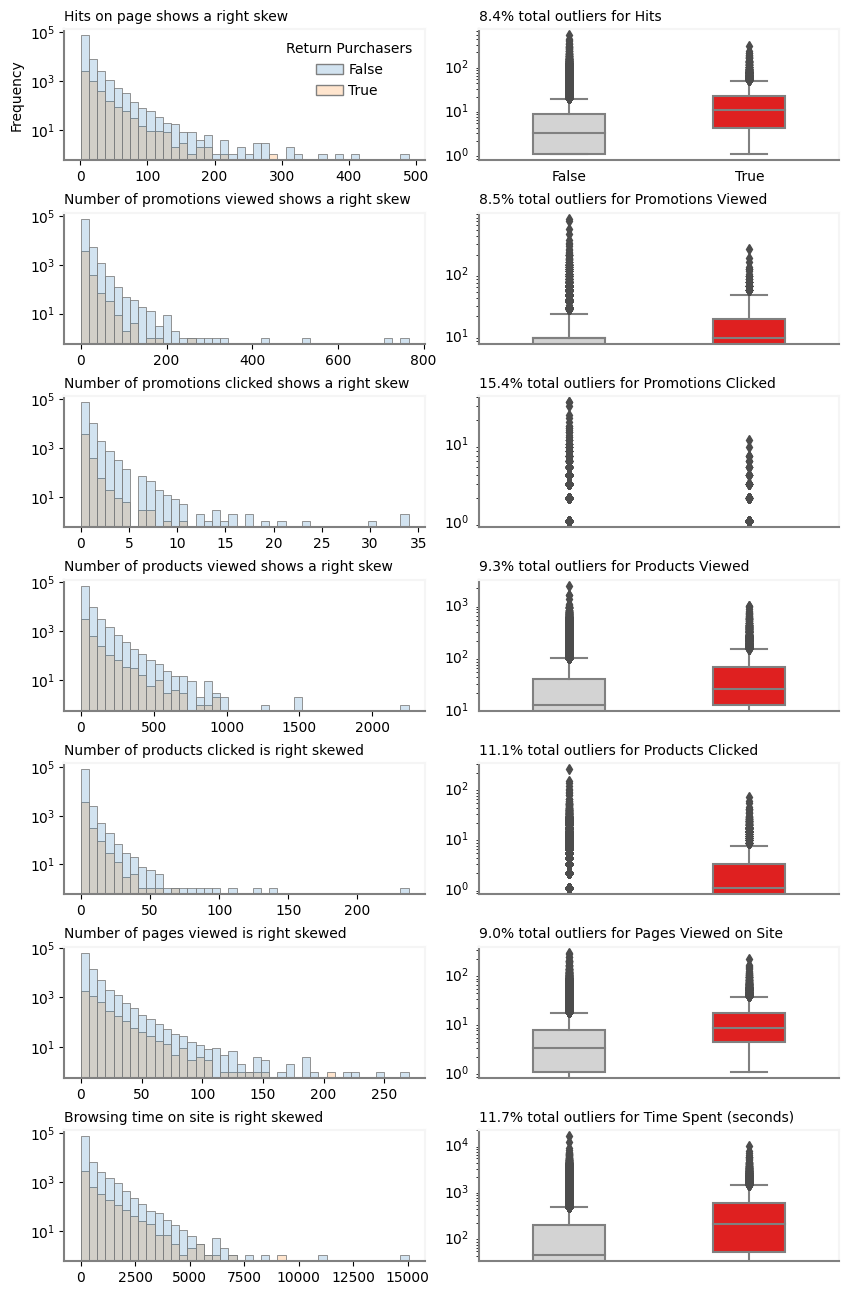

In [26]:
fig = plt.figure(figsize=(10, 16))
grid = plt.GridSpec(len(numerical_features), 2, hspace=0.4, wspace=0.15)
for k, (xvar, box_ptitle_suffix, hist_ptitle) in enumerate(
    zip(
        numerical_features,
        [
            "Hits",
            "Promotions Viewed",
            "Promotions Clicked",
            "Products Viewed",
            "Products Clicked",
            "Pages Viewed on Site",
            "Time Spent (seconds)",
        ],
        [
            "Hits on page shows a right skew",
            "Number of promotions viewed shows a right skew",
            "Number of promotions clicked shows a right skew",
            "Number of products viewed shows a right skew",
            "Number of products clicked is right skewed",
            "Number of pages viewed is right skewed",
            "Browsing time on site is right skewed",
        ],
    )
):
    ax1 = fig.add_subplot(grid[k, 0])
    ax2 = fig.add_subplot(grid[k, 1], xticklabels=[])

    data = df_train.astype({xvar: int, label: pd.BooleanDtype()}).copy()

    vh.plot_histogram(
        data,
        ax1,
        xvar=xvar,
        color_by_col=label,
        xlabel=None,
        ylabel="Frequency" if k == 0 else None,
        ptitle=hist_ptitle,
        axis_label_fontsize=10,
        num_bins=40,
        bin_edgecolor="grey",
        bin_transparency=0.2,
        set_xlog=False,
        set_ylog=True,
        legend_params=dict(
            loc="best",
            frameon=False,
            handletextpad=0.35,
            title="Return Purchasers",
        )
        if k == 0
        else dict(),
    )
    vh.plot_boxplot(
        data,
        ax2,
        xvar=xvar,
        ylabel=None,
        color_by_col=label,
        ptitle=(
            f"{ut.get_frac_outliers(data[xvar]):.1f}% "
            f"total outliers for {box_ptitle_suffix}"
        ),
        show_xticklabels=True if k == 0 else False,
        y_scale="log",
        box_width=0.4,
        label_color_palette={True: "red", False: "lightgrey"},
        color_properties={
            "boxprops": {"edgecolor": "grey"},
            "flierprops": {"color": "none"},
            "medianprops": {"color": "grey"},
            "whiskerprops": {"color": "grey"},
            "capprops": {"color": "grey"},
        },
        median_annotation_props=dict(),
        axis_label_fontsize=10,
    )

::: {.callout-tip title="Observations"}

1. For numerical features among return visitors who did not make a purchase
   - there is a wider range of outliers
   - the IQR range (height of the box) is more well-defined (smaller)
   - average value (horizontal line inside the box) is generally higher

   than for the same features among those visitors who did.
2. Based on univariate analaysis, the overall numerical features contain approximately 8-11% of outliers. *promotions clicked* is the only feature with more outliers (15%).
:::

### Conversion Rates Among Categorical Features

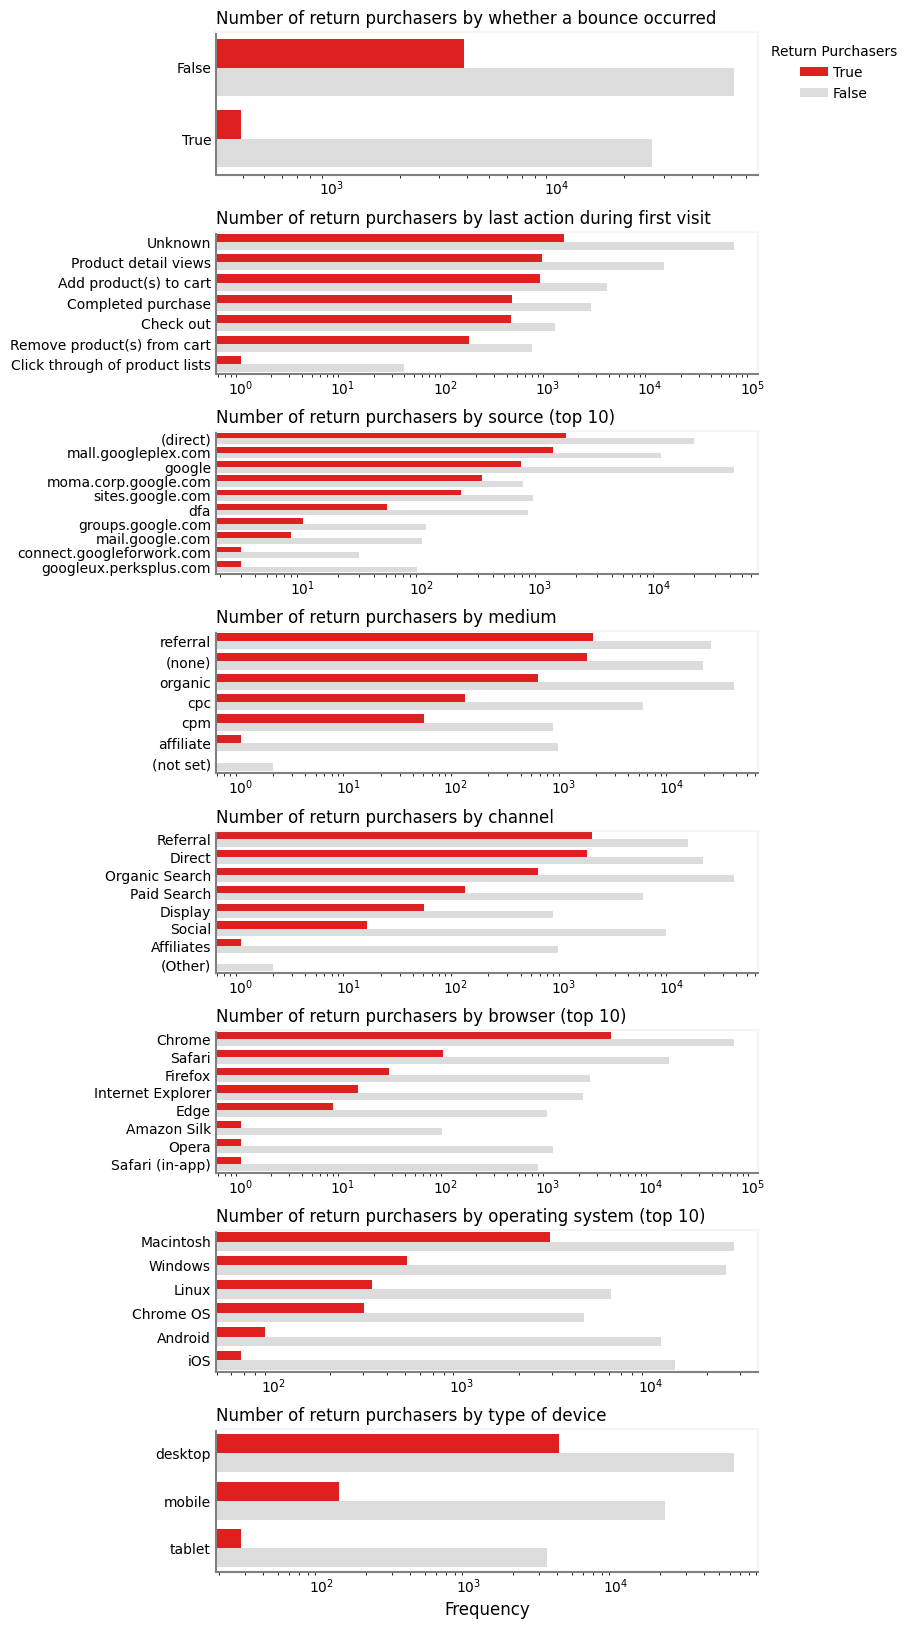

In [27]:
fig = plt.figure(figsize=(7, 20))
grid = plt.GridSpec(len(categorical_features), 1, hspace=0.4)
for k, (yvar, bar_ptitle_suffix) in enumerate(
    zip(
        categorical_features,
        [
            "whether a bounce occurred",
            "last action during first visit",
            "source",
            "medium",
            "channel",
            "browser",
            "operating system",
            "type of device",
        ],
    )
):
    data = (
        df_train.assign(bounces=lambda df: df["bounces"].map({0: False, 1: True}))
        .astype({label: pd.BooleanDtype()})
        .groupby([yvar, label], as_index=False)["fullvisitorid"]
        .count()
        .rename(columns={"fullvisitorid": "count"})
        .sort_values(by=[label, "count"], ascending=[True, False], ignore_index=True)
    )
    if yvar in ["os", "browser", "source"]:
        popular_cats_for_minority_class = (
            data.query(f"({label}) & (count > 0)")[yvar].unique().tolist()
        )[:10]
        data = data.query(f"{yvar}.isin(@popular_cats_for_minority_class)")
        ptitle = f"Number of return purchasers by {bar_ptitle_suffix} (top 10)"
    else:
        ptitle = f"Number of return purchasers by {bar_ptitle_suffix}"

    ax = fig.add_subplot(grid[k, 0])
    vh.plot_grouped_barchart(
        data,
        ax,
        yvar=yvar,
        ptitle=ptitle,
        color_by_col=label,
        label=label,
        xlabel="Frequency" if k == len(categorical_features) - 1 else None,
        x_scale="log",
        set_xlog=True,
        label_color_palette={True: "red", False: "gainsboro"},
        legend_params=(
            dict(
                loc="upper left",
                bbox_to_anchor=(1, 1),
                frameon=False,
                handletextpad=0.35,
                title="Return Purchasers",
            )
            if k == 0
            else dict()
        ),
        axis_label_fontsize=12,
    )

::: {.callout-tip title="Observations"}

1. (`bounces`) A smaller fraction of return purchasers bounced off the page than for non-return purchasers. It seems keeping visitors engaged during their first visit is a good indicator for getting their business during a return visit to the store.
2. (`desktop`) The largest fraction of return purchasers used a desktop computer during their first visit. This dataset captures visitors from as early as August 2016 to as late as August 2017. With increased mobile phone use since then, these proportions might have changed since then.
3. (`operating system`) The largest fraction of return purchasers used a desktop (Mac, Windows and Linux) to access the store during their first visit. This is not surprising based on the above observation about the high fraction desktop use among return purcasers.
4. (`browser`) Chrome was the dominant browser, ahead of a grouping of Safari and Firefox. The Microsoft Edge browser was only [released in July 2015](https://en.wikipedia.org/wiki/Microsoft_Edge), so it not surprising that Edge is a little further back from Safari and Firefox.
5. (`channel`, `medium` and `source`) Based on source, medium and channel, return purchasers
   - directly accessed the store's site ([manually typed in the URL of the store](https://www.ruleranalytics.com/blog/analytics/direct-traffic-google-analytics/))
     - medium=`None`
     - channel=`Direct`
     - source=`(direct)`
   - relied on referrals (visitor clicked a link to the store on another site - [1](https://support.google.com/analytics/answer/3297892?hl=en), [2](https://www.jellyfish.com/en-us/training/blog/google-analytics-channels-explained))
     - channel=`Referral`
     - medium=`Referral`
   - accessed the store site by [clicking on a link from a non-paid search result in a search engine](https://blog.hubspot.com/marketing/organic-search-definition-100-words)
     - channel=`Organic Search`
     - medium=`organic`
     
     during their first visit. From the chart for the `source` feature, we see that the dominant search engine (contributing to the organic search results) is Google Search.
6. (`last action`) Qualitatively, the largest **fraction** (ratio of red bar to grey bar) of return purchasers
   - checked out
   - completed a purchase
   - removed a product from their shopping cart

   as the last action during their first visit to the store. The largest **number** (length of red bar) of return purchasers
   - performed an action that could not be tracked by the embedded Google Analytics tracking script
   - viewed product details
   - added a product to their shopping cart

   as the last action during their first visit to the store.
:::

### Numerical Feature Interactions

::: {.callout-important}
## Slow Execution

As the length of the data grows (as more months of training data are used), it takes longer to retrieve feature interactions.
:::

In [28]:
dtypes_scatter_plot = {c: int for c in numerical_features}
dtypes_scatter_plot.update({label: pd.BooleanDtype()})
data = df_train.astype(dtypes_scatter_plot)[numerical_features + [label]].copy()

g = sns.pairplot(
    data,
    hue=label,
    corner=True,
    plot_kws=dict(edgecolor="white"),
    palette={True: "red", False: "gainsboro"},
    diag_kind="kde",
    diag_kws={"linewidth": 0, "fill": False},
)
g._legend.remove()
g.fig.subplots_adjust(top=1)
_ = g.fig.suptitle(
    "Visitors who did (red) & did not (lightgrey) make a purchase on a return visit"
)

::: {.callout-tip title="Observations"}

1. Inter-feature correlations are observed between hits and product clicks or between hits and page views. Qualitatively, the other feature interactions do not show evidence of a correlation.
:::

## ML Pipeline

As indicated in the EDA section, all non-ID features will be passed into the ML pipeline. The ML pipeline will first perform feature engineering and preprocessing. This step is named `preprocessor`. The next step of the pipeline (named `select`) will select features based on feature-to-feature correlations.

### Feature Selection

Highly correlated features will be dropped and all remaining features (low or moderately correlated to eachother) will be selected.

### Feature Engineering - SQL

As part of the data retrieval from the Google Analytics tracking data for the merchandise store's site, the following features of the first visit were engineered using SQL

1. `last_action`
   - last action performed during the first visit
2. `added_to_cart`
   - number of products added to shopping cart during the first visit

### Feature Engineering - Python

Feature engineering is performed on the raw data, before pre-processing. For each numerical feature, we'll extract three new features as the ratio to the mean. The intuition behind this transformation is that visitors with a higher-than-average number of pages viewed on their first visit have a higher likelihood of making a purchase on a return visit. This is implemented in `src/feature_helpers.py` using a `scikit-learn` [custom transformer](https://scikit-learn.org/stable/modules/preprocessing.html#custom-transformers).

### Feature Pre-Processing

A feature processing pipeline is defined with the following steps

1. numerical columns
   - feature engineering
   - normalization
2. categorical columns
   - frequency encoding
   - dummy encoding
3. feature selection
   - drop highly correlated features (r > 0.7)
   - keep weakly (r < 0.5) and moderately (r > 0.5 and r < 0.7) corelated features

### Pipeline

In the overall ML pipeline, preprocessing is performed in combination with under-sampling or over-sampling in order to handle the class imbalance. If the observations are undersampled, then this is done before preprocessing features. By comparison , if they are oversampled, then this is done after preprocessing features.

After preprocessing, the class-imbalance increases in favor of the minority class. The class imbalances can be the same after preprocessing using under- and over-sampling. The `sampling_strategy` hyperparameter determines the imbalance in the label after resampling. If hyperparameter is the same for over- and under-sampling then both approaches produce the same class imbalance after resampling. For this reason, equal class imbalances is possible with both approaches. With the same `sampling_strategy` hyperparameter, the number of remaining observations after resampling can be different depending on whether under- or over-sampling is used, since both resampling approaches work differently.

Over-sampling adds more observations in the minority class and so there are more observations in this class after over-sampling. For under-sampling, the number of such minority-class observations are unchanged, since observations are removed from the majority class.

In [29]:
numeric_transformer = Pipeline(
    steps=[
        ("aboveavg", fh.AboveAveragePagePromoEngager(numerical_features)),
        ("scaler", MinMaxScaler()),
    ]
)
categorical_freq_encoder = ColumnTransformer(
    transformers=[
        ("fe", RareLabelEncoder(variables=["source", "browser"]), categorical_features)
    ],
    remainder="passthrough",
)
categorical_transformer = Pipeline(
    steps=[
        ("rarecats", categorical_freq_encoder),
        ("dummy", OneHotEncoder(handle_unknown="ignore", dtype=int, drop="first")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

if resampling_approach == "us":
    pipe = Pipeline(
        steps=[
            ("resampler", RandomUnderSampler(random_state=88)),
            ("preprocessor", preprocessor),
            ("select", DropCorrelatedFeatures()),
        ]
    )
else:
    pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("select", DropCorrelatedFeatures()),
            ("resampler", RandomOverSampler(random_state=88)),
        ]
    )
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('aboveavg',
                                                                   AboveAveragePagePromoEngager(cols=['hits',
                                                                                                      'promos_displayed',
                                                                                                      'promos_clicked',
                                                                                                      'product_views',
                                                                                                      'product_clicks',
                                                                                                      'pageviews',
                                                                                                      'time_on_site'])),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['hits', 'promos_displayed',
                                                   'promos_clicked',
                                                   'product_views',
                                                   'product_clicks',
                                                   'page...
                                                                                                     'last_action',
                                                                                                     'source',
                                                                                                     'medium',
                                                                                                     'channelGrouping',
                                                                                                     'browser',
                                                                                                     'os',
                                                                                                     'deviceCategory'])])),
                                                                  ('dummy',
                                                                   OneHotEncoder(drop='first',
                                                                                 dtype=<class 'int'>,
                                                                                 handle_unknown='ignore'))]),
                                                  ['bounces', 'last_action',
                                                   'source', 'medium',
                                                   'channelGrouping', 'browser',
                                                   'os', 'deviceCategory'])])),
                ('select', DropCorrelatedFeatures()),
                ('resampler', RandomOverSampler(random_state=88))])

## Model Development

### Define Cross-Validator

A single validation fold (the validation data split) is used to validate the ML pipeline. A cross-validator is defined using `sklearn`'s `PredefinedSplit` to train the pipeline on the training data split and evaluate predictions on the validation data split.

In [30]:
split_index = [-1] * len(X_train) + [0] * len(X_val)
pds = PredefinedSplit(test_fold=split_index)

::: {.content-hidden}
### Define Scorer Objects for Evaluation Metrics
:::

In [31]:
scorers = mh.get_scorers("macro", "warn", None)

### Append ML Model to Pipeline

In [32]:
clf = models[model_type]
pipe.steps.append(["clf", clf])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('aboveavg',
                                                                   AboveAveragePagePromoEngager(cols=['hits',
                                                                                                      'promos_displayed',
                                                                                                      'promos_clicked',
                                                                                                      'product_views',
                                                                                                      'product_clicks',
                                                                                                      'pageviews',
                                                                                                      'time_on_site'])),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['hits', 'promos_displayed',
                                                   'promos_clicked',
                                                   'product_views',
                                                   'product_clicks',
                                                   'page...
                                                                                                     'channelGrouping',
                                                                                                     'browser',
                                                                                                     'os',
                                                                                                     'deviceCategory'])])),
                                                                  ('dummy',
                                                                   OneHotEncoder(drop='first',
                                                                                 dtype=<class 'int'>,
                                                                                 handle_unknown='ignore'))]),
                                                  ['bounces', 'last_action',
                                                   'source', 'medium',
                                                   'channelGrouping', 'browser',
                                                   'os', 'deviceCategory'])])),
                ('select', DropCorrelatedFeatures()),
                ('resampler', RandomOverSampler(random_state=88)),
                ['clf', BetaDistClassifier(random_state=88)]])

### Hyper-Parameter Tuning

In [33]:
gs = GridSearchCV(
    pipe,
    param_grid,
    cv=pds,
    scoring=scorers,
    verbose=2,
    refit=primary_metric,
)

Perform hyper-parameter tuning

In [34]:
%%time
gs.fit(X_train_val, y_train_val.astype(int))
print("Done with hyperparameter tuning")

Fitting 1 folds for each of 30 candidates, totalling 30 fits
[CV] END clf__a=0.2, clf__b=2.31, preprocessor__cat__rarecats__fe__ignore_format=True, preprocessor__cat__rarecats__fe__n_categories=1, preprocessor__cat__rarecats__fe__replace_with=other, preprocessor__cat__rarecats__fe__tol=0.1, resampler__sampling_strategy=0.1, select__threshold=0.7; total time=   1.0s
[CV] END clf__a=0.2, clf__b=2.25, preprocessor__cat__rarecats__fe__ignore_format=True, preprocessor__cat__rarecats__fe__n_categories=1, preprocessor__cat__rarecats__fe__replace_with=other, preprocessor__cat__rarecats__fe__tol=0.1, resampler__sampling_strategy=0.1, select__threshold=0.7; total time=   0.9s
[CV] END clf__a=0.2, clf__b=2.35, preprocessor__cat__rarecats__fe__ignore_format=True, preprocessor__cat__rarecats__fe__n_categories=1, preprocessor__cat__rarecats__fe__replace_with=other, preprocessor__cat__rarecats__fe__tol=0.1, resampler__sampling_strategy=0.1, select__threshold=0.7; total time=   0.9s
[CV] END clf__a=0.

### Get Validation Hyper-Parameters and Metrics

In [35]:
metrics_cols = [f"mean_test_{m}" for m in list(scorers)]
metrics_dtypes = {m: pd.Float32Dtype() for m in metrics_cols}
df_gs = pd.DataFrame(gs.cv_results_)
params_cols = df_gs.columns[df_gs.columns.str.startswith("param_")].tolist()
gs_cols = (
    ["resampling_approach", "clf"]
    + params_cols
    + ["params"]
    + metrics_cols
    + ["mean_fit_time", "mean_score_time"]
)
df_gs = (
    df_gs.assign(
        params=lambda df: df["params"].apply(json.dumps).astype(pd.StringDtype())
    )
    .assign(resampling_approach=resampling_approach)
    .assign(clf=type(pipe.named_steps["clf"]).__name__)
    .astype(metrics_dtypes)
    .astype({"resampling_approach": pd.StringDtype(), "clf": pd.StringDtype()})[gs_cols]
    .rename(
        columns={
            f"param_{resampling_approach}__sampling_strategy": "param__sampling_strategy"
        }
    )
)
with pd.option_context("display.max_columns", None):
    display(df_gs.drop(columns=["params"]))

,resampling_approach,clf,param_clf__a,param_clf__b,param_preprocessor__cat__rarecats__fe__ignore_format,param_preprocessor__cat__rarecats__fe__n_categories,param_preprocessor__cat__rarecats__fe__replace_with,param_preprocessor__cat__rarecats__fe__tol,param_resampler__sampling_strategy,param_select__threshold,mean_test_accuracy,mean_test_balanced_accuracy,mean_test_precision,mean_test_recall,mean_test_roc_auc,mean_test_f1,mean_test_fbeta05,mean_test_fbeta2,mean_test_pr_auc,mean_test_avg_precision,mean_fit_time,mean_score_time
0,os,BetaDistClassifier,0.2,2.31,True,1,other,0.1,0.1,0.7,0.937904,0.501539,0.501726,0.501539,0.501539,0.501568,0.501646,0.501536,0.034591,0.034205,0.836648,0.118831
1,os,BetaDistClassifier,0.2,2.25,True,1,other,0.1,0.1,0.7,0.935543,0.496308,0.496082,0.496308,0.496308,0.496183,0.496119,0.496255,0.032233,0.033905,0.812090,0.115707
2,os,BetaDistClassifier,0.2,2.35,True,1,other,0.1,0.1,0.7,0.939179,0.502867,0.503343,0.502867,0.502867,0.502983,0.503166,0.502888,0.035375,0.034318,0.802264,0.122692
3,os,BetaDistClassifier,0.2,2.4,True,1,other,0.1,0.1,0.7,0.940171,0.501376,0.501676,0.501376,0.501376,0.501346,0.501493,0.501327,0.035538,0.034193,0.800810,0.117762
4,os,BetaDistClassifier,0.2,2.5,True,1,other,0.1,0.1,0.7,0.94206,0.496341,0.495071,0.496341,0.496341,0.495448,0.495144,0.495935,0.034335,0.033921,0.789521,0.116408
5,os,BetaDistClassifier,0.3,2.31,True,1,other,0.1,0.1,0.7,0.919866,0.498214,0.498741,0.498214,0.498214,0.497814,0.498251,0.497846,0.034406,0.033984,0.829881,0.126483
6,os,BetaDistClassifier,0.3,2.25,True,1,other,0.1,0.1,0.7,0.91741,0.498947,0.499295,0.498947,0.498947,0.498194,0.498695,0.498343,0.035797,0.034027,0.815624,0.116943
7,os,BetaDistClassifier,0.3,2.35,True,1,other,0.1,0.1,0.7,0.921188,0.497562,0.498231,0.497562,0.497562,0.497366,0.497787,0.497321,0.033549,0.033949,0.822759,0.117708
8,os,BetaDistClassifier,0.3,2.4,True,1,other,0.1,0.1,0.7,0.923785,0.49757,0.498133,0.49757,0.49757,0.497508,0.497816,0.497444,0.03559,0.03395,0.800312,0.122950
9,os,BetaDistClassifier,0.3,2.5,True,1,other,0.1,0.1,0.7,0.928413,0.505978,0.504998,0.505978,0.505978,0.505274,0.505064,0.505637,0.032603,0.034598,0.794850,0.117124


### Get Best Hyper-Parameters

In [36]:
df_best_params = df_gs.sort_values(
    by=[f"mean_test_{primary_metric}"], ascending=False
).iloc[[0]]
df_best_params

,resampling_approach,clf,param_clf__a,param_clf__b,param_preprocessor__cat__rarecats__fe__ignore_format,param_preprocessor__cat__rarecats__fe__n_categories,param_preprocessor__cat__rarecats__fe__replace_with,param_preprocessor__cat__rarecats__fe__tol,param_resampler__sampling_strategy,param_select__threshold,...,mean_test_precision,mean_test_recall,mean_test_roc_auc,mean_test_f1,mean_test_fbeta05,mean_test_fbeta2,mean_test_pr_auc,mean_test_avg_precision,mean_fit_time,mean_score_time
9,os,BetaDistClassifier,0.3,2.5,True,1,other,0.1,0.1,0.7,...,0.504998,0.505978,0.505978,0.505274,0.505064,0.505637,0.032603,0.034598,0.79485,0.117124


### Set Best Hyper-Parameters in Pipeline

In [ ]:
best_params = json.loads(df_best_params["params"].iloc[0])

In [37]:
#| output: false
best_params

{'clf__a': 0.3,
 'clf__b': 2.5,
 'preprocessor__cat__rarecats__fe__ignore_format': True,
 'preprocessor__cat__rarecats__fe__n_categories': 1,
 'preprocessor__cat__rarecats__fe__replace_with': 'other',
 'preprocessor__cat__rarecats__fe__tol': 0.1,
 'resampler__sampling_strategy': 0.1,
 'select__threshold': 0.7}

Set best hyperparameters in new `Pipeline`

In [38]:
pipe.set_params(**best_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('aboveavg',
                                                                   AboveAveragePagePromoEngager(cols=['hits',
                                                                                                      'promos_displayed',
                                                                                                      'promos_clicked',
                                                                                                      'product_views',
                                                                                                      'product_clicks',
                                                                                                      'pageviews',
                                                                                                      'time_on_site'])),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['hits', 'promos_displayed',
                                                   'promos_clicked',
                                                   'product_views',
                                                   'product_clicks',
                                                   'page...
                                                                  ('dummy',
                                                                   OneHotEncoder(drop='first',
                                                                                 dtype=<class 'int'>,
                                                                                 handle_unknown='ignore'))]),
                                                  ['bounces', 'last_action',
                                                   'source', 'medium',
                                                   'channelGrouping', 'browser',
                                                   'os', 'deviceCategory'])])),
                ('select', DropCorrelatedFeatures(threshold=0.7)),
                ('resampler',
                 RandomOverSampler(random_state=88, sampling_strategy=0.1)),
                ['clf', BetaDistClassifier(a=0.3, b=2.5, random_state=88)]])

## ML Evaluation

### Train Best `Pipeline` Using Combined and Shuffled Training and Validation Data

In [39]:
#| echo: true
_ = pipe.fit(X_train_val_eval, y_train_val_eval)

CPU times: user 959 ms, sys: 52.4 ms, total: 1.01 s
Wall time: 1.01 s


### Make Predictions

[Soft predictions](https://ai.stackexchange.com/a/9636)

In [40]:
#| echo: true
#| output: false
y_train_val_eval_pred_proba = pd.DataFrame(
    pipe.predict_proba(X_train_val_eval)[:, 1], index=X_train_val_eval.index
).astype(pd.Float32Dtype())
y_test_pred_proba = pd.DataFrame(
    pipe.predict_proba(X_test)[:, 1], index=X_test.index
).astype(pd.Float32Dtype())

/opt/conda/envs/train/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Convert to hard labels, using discrimination threshold of 0.5

In [41]:
#| echo: true
y_train_val_eval_pred = (y_train_val_eval_pred_proba.squeeze() >= 0.5).astype(
    pd.Int8Dtype()
)
y_test_pred = (y_test_pred_proba.squeeze() >= 0.5).astype(pd.Int8Dtype())

### Get Evaluation Metrics

In [42]:
df_metrics = mh.calculate_metrics(
    y_train_val_eval,
    y_train_val_eval_pred,
    y_train_val_eval_pred_proba,
    y_test,
    y_test_pred,
    y_test_pred_proba,
)
with pd.option_context("display.max_columns", None):
    display(df_metrics.style.background_gradient(
    cmap="YlOrRd", subset=["train_val", "test"]
).set_properties(**{"font-size": "14px"}))

split,metric,train_val,test
0,accuracy,0.919483,0.940538
1,balanced_accuracy,0.501968,0.499218
2,precision,0.047763,0.022135
3,recall,0.501968,0.499218
4,roc_auc,0.501968,0.499218
5,f1,0.502007,0.498453
6,fbeta05,0.502060,0.498946
7,fbeta2,0.501977,0.498594
8,pr_auc,0.043754,0.023227
9,avg_precision,0.043898,0.023027


CPU times: user 385 ms, sys: 0 ns, total: 385 ms
Wall time: 385 ms


### Optimal Discrimination Threshold Tuning

Discrimination or decision threshold is the probability at which the minority class is chosen over the majority class, when converting soft predictions to hard labels. By default, the threshold is set at 0.5. For imbalanced data, the default threshold of 0.5 can give poor model performance. One possible approach to improving the performance of a model when working with imbalanced data is to vary the discrimination threshold (or [threshold tuning](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)), which in-turn varies the sensitivity of the model to false positives, etc. In this way, it is possible to use a brute-force grid search to find the optimal threshold for a particular use-case, based on one or more evaluation metrics.

From varying the threshold using predictions made using the best pipeline, show

1. metrics for default threshold of 0.5
2. descriptive statistics for metrics as threshold is varied

In [43]:
#| output: false
df_thresholds = skh.get_threshold_tuning_scores(
    y_test,
    y_test_pred_proba.squeeze(),
    thresholds=np.arange(0, 1, 0.01),
    average="macro",
    zero_division='warn',
    sample_weight=None,
)
df_threshold_stats = skh.get_threshold_stats(df_thresholds)
display(
    df_threshold_stats.style.background_gradient(cmap="YlOrRd")
    .set_properties(**{"font-size": "14px"})
)

/opt/conda/envs/train/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/train/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,metric,t=0.5,mean,std,min,25%,50%,75%,max
0,accuracy,0.940538,0.870065,0.159745,0.023061,0.834557,0.939248,0.970703,0.976939
1,balanced_accuracy,0.499218,0.498920,0.003865,0.486641,0.497899,0.499962,0.501161,0.509339
2,precision,0.022135,0.028837,0.019977,0.000000,0.021916,0.022955,0.031250,0.142857
3,recall,0.499218,0.498920,0.003865,0.486641,0.497899,0.499962,0.501161,0.509339
4,roc_auc,0.499218,0.498920,0.003865,0.486641,0.497899,0.499962,0.501161,0.509339
5,f1,0.498453,0.472650,0.061605,0.022541,0.473025,0.495491,0.498594,0.504218
6,fbeta05,0.498946,0.483591,0.052170,0.014330,0.487063,0.495884,0.499410,0.504713
7,fbeta2,0.498594,0.469885,0.064818,0.052783,0.469361,0.497600,0.499683,0.504074
8,avg_precision,0.023027,0.023036,0.000183,0.022505,0.022969,0.023061,0.023161,0.023495


CPU times: user 6.23 s, sys: 1.83 ms, total: 6.23 s
Wall time: 6.24 s


Show a visualization of evaluation metrics relative to the discrimination threshold

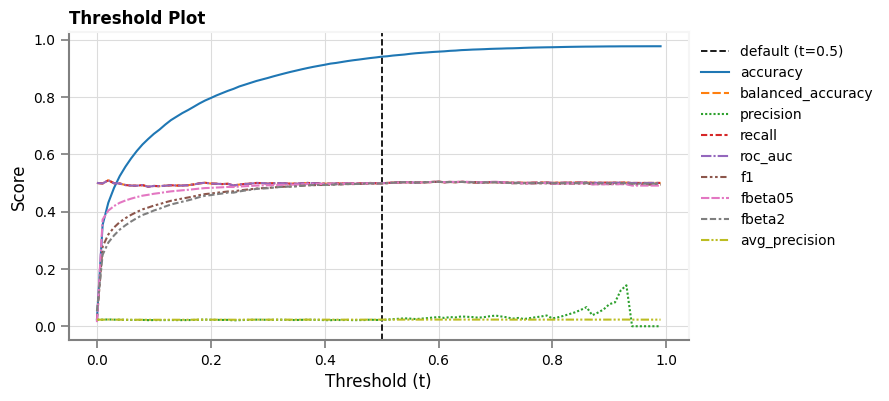

In [44]:
vh.plot_multi_line_threshold_chart(
    df_thresholds.set_index("t"),
    ptitle_str="Threshold Plot",
    xlabel="Threshold (t)",
    ylabel="Score",
    title_fontsize=12,
    axis_label_fontsize=12,
    figsize=(8, 4),
)

::: {.callout-tip title="Observations"}

1. To be done.
:::

### Train Best `Pipeline` Using All Available Combined and Shuffled Data

In [45]:
#| echo: true
_ = pipe.fit(X, y)

CPU times: user 1.12 s, sys: 64.3 ms, total: 1.19 s
Wall time: 1.19 s


### Get Validation and Evaluation Metrics, Feature Metadata and Observation Metadata

Get metrics and metadata for model evaluation

In [46]:
df_eval_metrics_metadata = pd.concat(
    [
        # best nested run
        df_best_params[
            df_best_params.columns[~df_best_params.columns.str.startswith("mean_")]
        ].reset_index(drop=True),
        # parent run
        # - evaluation metrics on train+val and test splits using hyperparameters
        #   from best nested run
        df_metrics.set_index("metric")
        .stack()
        .reset_index()
        .assign(metric=lambda df: df["split"].str.cat(df["metric"], sep="_"))
        .drop(columns=["split"])
        .set_index("metric")
        .transpose()
        .reset_index(drop=True),
    ],
    axis=1,
)
df_eval_metrics_metadata

,resampling_approach,clf,param_clf__a,param_clf__b,param_preprocessor__cat__rarecats__fe__ignore_format,param_preprocessor__cat__rarecats__fe__n_categories,param_preprocessor__cat__rarecats__fe__replace_with,param_preprocessor__cat__rarecats__fe__tol,param_resampler__sampling_strategy,param_select__threshold,...,train_val_f1,test_f1,train_val_fbeta05,test_fbeta05,train_val_fbeta2,test_fbeta2,train_val_pr_auc,test_pr_auc,train_val_avg_precision,test_avg_precision
0,os,BetaDistClassifier,0.3,2.5,True,1,other,0.1,0.1,0.7,...,0.502007,0.498453,0.50206,0.498946,0.501977,0.498594,0.043754,0.023227,0.043898,0.023027


Combine metrics and metadata for model validation and evaluation, and append experiment ID and run ID

In [47]:
df_expt_run_metrics = pd.concat(
    [
        # model validation, using validation data split
        df_gs.rename(
            columns=dict(
                zip(
                    list(df_gs),
                    df_gs.columns.str.removeprefix("mean_").tolist(),
                )
            )
        )
        # indicate this was from hyper-parameter optimization
        .assign(experiment_run_type="nested"),
        # model evaluation, using test data split
        df_eval_metrics_metadata
        # indicate this was from evaluation using best hyper-parameters
        .assign(experiment_run_type="parent"),
    ],
    ignore_index=True,
)
# add observation and feature metadata
df_expt_run_metrics = df_expt_run_metrics.assign(
    # observation metadata
    train_start_date=train_start_date,
    test_end_date=test_end_date,
    num_observations=len(df_train_val_eval),
    # feature metadata
    num_columns=df_train_val_eval.shape[1],
    column_names=json.dumps(list(df_train_val_eval)),
)
# set column datatypes
metrics_cols_overall = df_expt_run_metrics.columns[
    (
        df_expt_run_metrics.columns.str.startswith("train_val_")
        | df_expt_run_metrics.columns.str.startswith("test_")
    )
    & (~df_expt_run_metrics.columns.isin(["test_end_date"]))
].tolist() + ["fit_time", "score_time"]
df_expt_run_metrics = (
    df_expt_run_metrics.astype(
        dict(zip(metrics_cols_overall, [pd.Float32Dtype()] * len(metrics_cols_overall)))
    )
    .astype(dict(zip(params_cols, [pd.StringDtype()] * len(params_cols))))
    .astype(
        {
            "experiment_run_type": pd.StringDtype(),
            "train_start_date": pd.StringDtype(),
            "test_end_date": pd.StringDtype(),
            "num_observations": pd.Int32Dtype(),
            "num_columns": pd.Int32Dtype(),
            "column_names": pd.StringDtype(),
        }
    )
)
with pd.option_context("display.max_columns", None):
    display(df_expt_run_metrics)

,resampling_approach,clf,param_clf__a,param_clf__b,param_preprocessor__cat__rarecats__fe__ignore_format,param_preprocessor__cat__rarecats__fe__n_categories,param_preprocessor__cat__rarecats__fe__replace_with,param_preprocessor__cat__rarecats__fe__tol,param_resampler__sampling_strategy,param_select__threshold,params,test_accuracy,test_balanced_accuracy,test_precision,test_recall,test_roc_auc,test_f1,test_fbeta05,test_fbeta2,test_pr_auc,test_avg_precision,fit_time,score_time,experiment_run_type,train_val_accuracy,train_val_balanced_accuracy,train_val_precision,train_val_recall,train_val_roc_auc,train_val_f1,train_val_fbeta05,train_val_fbeta2,train_val_pr_auc,train_val_avg_precision,train_start_date,test_end_date,num_observations,num_columns,column_names
0,os,BetaDistClassifier,0.2,2.31,True,1,other,0.1,0.1,0.7,"{""clf__a"": 0.2, ""clf__b"": 2.31, ""preprocessor_...",0.937904,0.501539,0.501726,0.501539,0.501539,0.501568,0.501646,0.501536,0.034591,0.034205,0.836648,0.118831,nested,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,20160901,20170228,113728,28,"[""fullvisitorid"", ""visitId"", ""visitNumber"", ""v..."
1,os,BetaDistClassifier,0.2,2.25,True,1,other,0.1,0.1,0.7,"{""clf__a"": 0.2, ""clf__b"": 2.25, ""preprocessor_...",0.935543,0.496308,0.496082,0.496308,0.496308,0.496183,0.496119,0.496255,0.032233,0.033905,0.81209,0.115707,nested,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,20160901,20170228,113728,28,"[""fullvisitorid"", ""visitId"", ""visitNumber"", ""v..."
2,os,BetaDistClassifier,0.2,2.35,True,1,other,0.1,0.1,0.7,"{""clf__a"": 0.2, ""clf__b"": 2.35, ""preprocessor_...",0.939179,0.502867,0.503343,0.502867,0.502867,0.502983,0.503166,0.502888,0.035375,0.034318,0.802264,0.122692,nested,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,20160901,20170228,113728,28,"[""fullvisitorid"", ""visitId"", ""visitNumber"", ""v..."
3,os,BetaDistClassifier,0.2,2.4,True,1,other,0.1,0.1,0.7,"{""clf__a"": 0.2, ""clf__b"": 2.4, ""preprocessor__...",0.940171,0.501376,0.501676,0.501376,0.501376,0.501346,0.501493,0.501327,0.035538,0.034193,0.80081,0.117762,nested,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,20160901,20170228,113728,28,"[""fullvisitorid"", ""visitId"", ""visitNumber"", ""v..."
4,os,BetaDistClassifier,0.2,2.5,True,1,other,0.1,0.1,0.7,"{""clf__a"": 0.2, ""clf__b"": 2.5, ""preprocessor__...",0.94206,0.496341,0.495071,0.496341,0.496341,0.495448,0.495144,0.495935,0.034335,0.033921,0.789521,0.116408,nested,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,20160901,20170228,113728,28,"[""fullvisitorid"", ""visitId"", ""visitNumber"", ""v..."
5,os,BetaDistClassifier,0.3,2.31,True,1,other,0.1,0.1,0.7,"{""clf__a"": 0.3, ""clf__b"": 2.31, ""preprocessor_...",0.919866,0.498214,0.498741,0.498214,0.498214,0.497814,0.498251,0.497846,0.034406,0.033984,0.829881,0.126483,nested,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,20160901,20170228,113728,28,"[""fullvisitorid"", ""visitId"", ""visitNumber"", ""v..."
6,os,BetaDistClassifier,0.3,2.25,True,1,other,0.1,0.1,0.7,"{""clf__a"": 0.3, ""clf__b"": 2.25, ""preprocessor_...",0.91741,0.498947,0.499295,0.498947,0.498947,0.498194,0.498695,0.498343,0.035797,0.034027,0.815624,0.116943,nested,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,20160901,20170228,113728,28,"[""fullvisitorid"", ""visitId"", ""visitNumber"", ""v..."
7,os,BetaDistClassifier,0.3,2.35,True,1,other,0.1,0.1,0.7,"{""clf__a"": 0.3, ""clf__b"": 2.35, ""preprocessor_...",0.921188,0.497562,0.498231,0.497562,0.497562,0.497366,0.497787,0.497321,0.033549,0.033949,0.822759,0.117708,nested,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,20160901,20170228,113728,28,"[""fullvisitorid"", ""visitId"", ""visitNumber"", ""v..."
8,os,BetaDistClassifier,0.3,2.4,True,1,other,0.1,0.1,0.7,"{""clf__a"": 0.3, ""clf__b"": 2.4, ""preprocessor__...",0.923785,0.49757,0.498133,0.49757,0.49757,0.497508,0.497816,0.497444,0.03559,0.03395,0.800312,0.12295,nested,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,20160901,20170228,113728,28,"[""ful

::: {.content-hidden}
Get primary metric on test set for best `Pipeline`
:::

In [48]:
best_model_eval_score = df_eval_metrics_metadata[f"test_{primary_metric}"].iloc[0]

::: {.content-hidden}
## Combine All Processed Data Used During Evaluation
:::

::: {.content-hidden}
Get all data used during model evaluation
:::

In [ ]:
df_train_val_eval_test = pd.concat(
    [
        (
            df_train_val_eval.assign(split_type="train_val")
            .assign(score=y_train_val_eval_pred_proba)
            .assign(predicted_score_label=True)  # minority class
            .assign(predicted_label=y_train_val_eval_pred)
        ),
        (
            df_test.assign(split_type="test")
            .assign(score=y_test_pred_proba)
            .assign(predicted_score_label=True)  # minority class
            .assign(predicted_label=y_test_pred)
        ),
    ]
).astype(
    {
        "source": pd.CategoricalDtype(),
        "medium": pd.CategoricalDtype(),
        "channelGrouping": pd.CategoricalDtype(),
        "browser": pd.CategoricalDtype(),
        "os": pd.CategoricalDtype(),
        "split_type": pd.CategoricalDtype(),
        "score": pd.Float32Dtype(),
        "predicted_score_label": pd.BooleanDtype(),
        "predicted_label": pd.CategoricalDtype(),
    }
)

In [49]:
#| output: false
display(df_train_val_eval_test.head())
display(df_train_val_eval_test.dtypes.rename("dtype").to_frame())

,fullvisitorid,visitId,visitNumber,visitStartTime,quarter,month,day_of_month,day_of_week,hour,minute,...,time_on_site,browser,os,deviceCategory,added_to_cart,made_purchase_on_future_visit,split_type,score,predicted_score_label,predicted_label
23964,5690894220313921844,1473918114,1,2016-09-14 22:41:54,3,9,14,4,22,41,...,91,Edge,Windows,desktop,0,0,train_val,0.056789,True,0
37784,7628877966246977804,1483240263,1,2016-12-31 19:11:03,4,12,31,7,19,11,...,174,Chrome,Android,mobile,0,0,train_val,0.125737,True,0
28030,896681389035670634,1475862063,1,2016-10-07 10:41:03,4,10,7,6,10,41,...,270,Chrome,Macintosh,desktop,0,0,train_val,0.000727,True,0
30142,4851086048492726893,1481819046,1,2016-12-15 08:24:06,4,12,15,5,8,24,...,0,Chrome,Android,mobile,0,0,train_val,0.019808,True,0
15163,4033680816535906817,1485870769,1,2017-01-31 05:52:51,1,1,31,3,5,52,...,32,Safari,Macintosh,desktop,0,0,train_val,0.194653,True,0


,dtype
fullvisitorid,string[python]
visitId,string[python]
visitNumber,Int8
visitStartTime,datetime64[ns]
quarter,Int8
month,Int8
day_of_month,Int8
day_of_week,Int8
hour,Int8
minute,Int8


## ML Experiment Tracking

### Set up MLFlow Experiment

In [50]:
#| echo: true
#| output: false
client = MlflowClient(tracking_uri=mlflow.get_tracking_uri())
if not client.get_experiment_by_name(mlflow_expt_name):
    experiment_id = client.create_experiment(
        mlflow_expt_name,
        artifact_location=mlflow_artifact_fpath,
        tags={"version": "v1", "priority": "P1"},
    )
    client.set_experiment_tag(experiment_id, "demo", "mydemo")
    print(f"Created new experiment with ID = {experiment_id}")
else:
    experiment_id = client.get_experiment_by_name(mlflow_expt_name).experiment_id
    print(f"Retrieved existing experiment with ID = {experiment_id}")

2023/06/05 22:52:27 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/06/05 22:52:27 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

Created new experiment with ID = 1


### Track Experiment Run Outputs (Metrics and Metadata)

In [51]:
#| echo: true
#| output: false
with mlflow.start_run(experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    expt_run_fpath = os.path.join(
        raw_data_dir, f'ml__run_{run_id}__expt_{experiment_id}.parquet.gzip'
    )

    # export validation metrics to file and log as MLFlow artifact
    (
        df_expt_run_metrics.assign(experiment_id=experiment_id)
        .assign(run_id=run_id)
        .to_parquet(expt_run_fpath, index=False, compression='gzip', engine='pyarrow')
    )
    mlflow.log_artifact(expt_run_fpath)
    print(
        "Logged metrics and metadata DataFrame as artifact in file "
        f"{os.path.basename(expt_run_fpath)}"
    )

    # export combined processed data to file and log as MLFlow artifact
    proc_data_fpath = os.path.join(
        processed_data_dir, f'processed_data__run_{run_id}__expt_{experiment_id}.parquet.gzip'
    )
    df_train_val_eval_test.to_parquet(
        proc_data_fpath, index=False, compression='gzip', engine='pyarrow'
    )
    mlflow.log_artifact(proc_data_fpath)
    print(
        f"Logged processed data used during training and evaluation in file "
        f"{os.path.basename(proc_data_fpath)}"
    )

    # export threshold tuning outputs to file and log as MLFlow artifact
    threshold_data_fpath = os.path.join(
        processed_data_dir,
        f'threshold_tuning_data__run_{run_id}__expt_{experiment_id}.parquet.gzip',
    )
    df_thresholds.to_parquet(
        threshold_data_fpath, index=False, compression='gzip', engine='pyarrow'
    )
    mlflow.log_artifact(threshold_data_fpath)
    print(
        f"Logged data from threshold tuning used test data in file "
        f"{os.path.basename(threshold_data_fpath)}"
    )

    # log evaluation metrics
    mlflow.log_metrics(
        df_eval_metrics_metadata.select_dtypes(pd.Float64Dtype()).transpose().to_dict(
            orient="dict"
        )[0]
    )
    print("Logged metrics evaluated against combined train+validation and test data splits")

    curr_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = (
        f"{model_type}_{train_start_date}_{test_end_date}_{X.shape[0]}_feats"
        f"__{curr_datetime}"
    )
    _ = mlflow.sklearn.log_model(
        sk_model=pipe,
        await_registration_for=None,
        artifact_path="model",
        serialization_format='cloudpickle',
        registered_model_name=model_name,
    )
    print(
        f"Logged best {model_type} model (with score of {best_model_eval_score:.3f}), "
        "after training on all data"
    )

Logged metrics and metadata DataFrame as artifact in file ml__run_742cf152d5094be0b686edf910c7d398__expt_1.parquet.gzip
Logged processed data used during training and evaluation in file processed_data__run_742cf152d5094be0b686edf910c7d398__expt_1.parquet.gzip
Logged data from threshold tuning used test data in file threshold_tuning_data__run_742cf152d5094be0b686edf910c7d398__expt_1.parquet.gzip
Logged metrics evaluated against combined train+validation and test data splits
Logged best BetaDistClassifier model (with score of 0.499), after training on all data
CPU times: user 981 ms, sys: 169 ms, total: 1.15 s
Wall time: 2.75 s


/opt/conda/envs/train/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'BetaDistClassifier_20160901_20170228_133892_feats__20230605_225228'.
Created version '1' of model 'BetaDistClassifier_20160901_20170228_133892_feats__20230605_225228'.


::: {.content-hidden}
Add a description to the model
:::

In [52]:
_ = client.update_model_version(
    name=model_name,
    version=1,
    description=(
        f"Best {model_type} model with {primary_metric} score of "
        f"{best_model_eval_score:.10f}"
    ),
)

CPU times: user 2.06 ms, sys: 3.38 ms, total: 5.44 ms
Wall time: 11.3 ms


### Non-MLFlow Monitoring

Get untrained version of ML `Pipeline`

In [53]:
pipe_new = clone(pipe)
pipe_new

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('aboveavg',
                                                                   AboveAveragePagePromoEngager(cols=['hits',
                                                                                                      'promos_displayed',
                                                                                                      'promos_clicked',
                                                                                                      'product_views',
                                                                                                      'product_clicks',
                                                                                                      'pageviews',
                                                                                                      'time_on_site'])),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['hits', 'promos_displayed',
                                                   'promos_clicked',
                                                   'product_views',
                                                   'product_clicks',
                                                   'page...
                                                                  ('dummy',
                                                                   OneHotEncoder(drop='first',
                                                                                 dtype=<class 'int'>,
                                                                                 handle_unknown='ignore'))]),
                                                  ['bounces', 'last_action',
                                                   'source', 'medium',
                                                   'channelGrouping', 'browser',
                                                   'os', 'deviceCategory'])])),
                ('select', DropCorrelatedFeatures(threshold=0.7)),
                ('resampler',
                 RandomOverSampler(random_state=88, sampling_strategy=0.1)),
                ['clf', BetaDistClassifier(a=0.3, b=2.5, random_state=88)]])

::: {.content-hidden}
[Verify that](https://stackoverflow.com/a/74122815/4057186)

1. original `scikit-learn` ML `Pipeline` object is trained
2. new `scikit-learn` ML `Pipeline` object is not trained
:::

In [54]:
#| output: false
for pipe_obj, pipe_type in zip([pipe, pipe_new], ['Original', 'New']):
    try:
        check_is_fitted(pipe_obj)
        print(f"{pipe_type} Pipeline is trained")
    except NotFittedError as e:
        print(f"{pipe_type} Pipeline is not trained")

Original Pipeline is trained
New Pipeline is not trained


::: {.content-hidden}
Create filepath to export untrained ML `Pipeline`
:::

In [55]:
#| output: false
model_rub_dir_path = os.path.join(models_dir, run_id, 'artifacts', 'model')
os.makedirs(model_rub_dir_path, exist_ok=True)
print(f"Created filepath for untrained model at {model_rub_dir_path}")

Created filepath for untrained model at ../models/742cf152d5094be0b686edf910c7d398/artifacts/model


Export untrained model object to disk

In [56]:
#| echo: true
model_filepath = os.path.join(model_rub_dir_path, 'model.joblib')
_ = joblib.dump(pipe_new, model_filepath)

## Next Step

The trained model associated with the best experiment run (having the best evaluation metric) will be retrieved. This model will be registered in the MLFlow model registry so that it can be accessed in production to make inference predictions.